In [ ]:
# PREDICTING ICU MORTALITY USING ML
# A step-by-step guide with hyperparameter-tuned Random Forests
# By: Humberto Arias

# VOICEOVER: Welcome to this step-by-step tutorial on predicting ICU mortality using machine learning.
# In this presentation, I’ll guide you through the entire process, from data preprocessing and feature engineering to model training,
# evaluation, and interpretation. We’ll be using a Random Forest model and applying various techniques
# to improve its performance and interpret its predictions. Let’s dive in!

# VOICEOVER: Our goal here is to predict ICU mortality based on a range of patient data.
# We’re working with a dataset that includes demographic information, ICU stay details, and some clinical indicators.
# We’ll use Random Forests, a versatile model well-suited for handling complex data and class imbalances.
# In the end, we aim to create a model that can reliably predict patient mortality, which could support clinicians in making risk assessments.

# STEP 1: LOAD AND INSPECT THE DATA
import pandas as pd
import numpy as np
from google.colab import drive

drive.mount('/content/drive')

# Load DataFrames (adjust paths if needed)
admissions = pd.read_csv('/content/drive/My Drive/MIMICfull/ADMISSIONS.csv')
patients = pd.read_csv('/content/drive/My Drive/MIMICfull/PATIENTS.csv')
icustays = pd.read_csv('/content/drive/My Drive/MIMICfull/ICUSTAYS.csv')
diagnoses_icd = pd.read_csv('/content/drive/My Drive/MIMICfull/DIAGNOSES_ICD.csv')

# Preview the first few rows of each DataFrame to understand their structure
print("ADMISSIONS")
print(admissions.head())
print("\nPATIENTS")
print(patients.head())
print("\nICUSTAYS")
print(icustays.head())
print("\nDIAGNOSES_ICD")
print(diagnoses_icd.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ADMISSIONS
   row_id  subject_id  hadm_id            admittime            dischtime  \
0       1           2   163353  2138-07-17 19:04:00  2138-07-21 15:48:00   
1       2           3   145834  2101-10-20 19:08:00  2101-10-31 13:58:00   
2       4           5   178980  2103-02-02 04:31:00  2103-02-04 12:15:00   
3       6           7   118037  2121-05-23 15:05:00  2121-05-27 11:57:00   
4       7           8   159514  2117-11-20 10:22:00  2117-11-24 14:20:00   

  deathtime admission_type         admission_location discharge_location  \
0       NaN        NEWBORN  PHYS REFERRAL/NORMAL DELI               HOME   
1       NaN      EMERGENCY       EMERGENCY ROOM ADMIT                SNF   
2       NaN        NEWBORN  PHYS REFERRAL/NORMAL DELI               HOME   
3       NaN        NEWBORN  PHYS REFERRAL/NORMAL DELI               HOME   
4       NaN        NEWB

In [ ]:
# STEP 2: DATA PREPROCESSING
# Create target variable from the ADMISSIONS table
admissions['mortality'] = admissions['deathtime'].notnull().astype(int)

# Merge ADMISSIONS with ICUSTAYS to get a dataset focused on ICU admissions
icu_data = icustays.merge(admissions[['hadm_id', 'mortality']], on='hadm_id', how='inner')

# Further join with PATIENTS for demographic data
icu_data = icu_data.merge(patients[['subject_id', 'gender', 'dob']], on='subject_id', how='left')

# Display the resulting dataset and check for missing values
print(icu_data.head())
print(icu_data.isnull().sum())


   row_id  subject_id  hadm_id  icustay_id dbsource first_careunit  \
0       1           2   163353      243653  carevue           NICU   
1       2           3   145834      211552  carevue           MICU   
2       4           5   178980      214757  carevue           NICU   
3       6           7   118037      278444  carevue           NICU   
4       7           7   118037      236754  carevue           NICU   

  last_careunit  first_wardid  last_wardid               intime  \
0          NICU            56           56  2138-07-17 21:20:07   
1          MICU            12           12  2101-10-20 19:10:11   
2          NICU            56           56  2103-02-02 06:04:24   
3          NICU            56           56  2121-05-23 15:35:29   
4          NICU            56           56  2121-05-25 03:26:01   

               outtime     los  mortality gender                  dob  
0  2138-07-17 23:32:21  0.0918          0      M  2138-07-17 00:00:00  
1  2101-10-26 20:43:09  6.0646  

In [ ]:
# STEP 3: FEATURE ENGINEERING - Part I

# VOICEOVER: Feature engineering is the process of creating new variables that provide useful information for the model.
# Here, we’ve engineered key features such as admission_age, length_of_stay, and diagnosis_count.
# These features are likely to correlate with patient outcomes. For example, an older age or a higher diagnosis count might indicate a higher risk.
# Creating these features helps our model capture essential patterns in the data.

# Extract year from dob and admittime to calculate approximate age at admission
admissions_patients = admissions.merge(patients[['subject_id', 'dob']], on='subject_id', how='left')

# Convert date columns to datetime format and extract the year
admissions_patients['admittime'] = pd.to_datetime(admissions_patients['admittime'], errors='coerce')
admissions_patients['dob'] = pd.to_datetime(admissions_patients['dob'], errors='coerce')

# Calculate approximate age by subtracting the year of dob from the year of admittime
admissions_patients['admission_age'] = admissions_patients['admittime'].dt.year - admissions_patients['dob'].dt.year

# Handle unrealistic ages (e.g., age < 0 or age > 120)
admissions_patients['admission_age'] = admissions_patients['admission_age'].apply(lambda x: x if 0 <= x <= 120 else np.nan)

# Fill NaN values in admission_age with the median value
median_age = admissions_patients['admission_age'].median()
admissions_patients['admission_age'] = admissions_patients['admission_age'].fillna(median_age)

# Now join this calculated 'admission_age' back to icu_data
icu_data = icu_data.merge(admissions_patients[['hadm_id', 'admission_age']], on='hadm_id', how='left')

# Display the first few rows to verify
print(icu_data.head())

   row_id  subject_id  hadm_id  icustay_id dbsource first_careunit  \
0       1           2   163353      243653  carevue           NICU   
1       2           3   145834      211552  carevue           MICU   
2       4           5   178980      214757  carevue           NICU   
3       6           7   118037      278444  carevue           NICU   
4       7           7   118037      236754  carevue           NICU   

  last_careunit  first_wardid  last_wardid               intime  \
0          NICU            56           56  2138-07-17 21:20:07   
1          MICU            12           12  2101-10-20 19:10:11   
2          NICU            56           56  2103-02-02 06:04:24   
3          NICU            56           56  2121-05-23 15:35:29   
4          NICU            56           56  2121-05-25 03:26:01   

               outtime     los  mortality gender                  dob  \
0  2138-07-17 23:32:21  0.0918          0      M  2138-07-17 00:00:00   
1  2101-10-26 20:43:09  6.0646

In [ ]:
# STEP 3: FEATURE ENGINEERING - Part II
# Calculate ICU length of stay in days
icustays['intime'] = pd.to_datetime(icustays['intime'], errors='coerce')
icustays['outtime'] = pd.to_datetime(icustays['outtime'], errors='coerce')
icustays['icu_length_of_stay'] = (icustays['outtime'] - icustays['intime']).dt.total_seconds() / (60 * 60 * 24)

# Drop 'icu_length_of_stay' from icu_data if it exists to avoid duplication in the merge
if 'icu_length_of_stay' in icu_data.columns:
    icu_data = icu_data.drop(columns=['icu_length_of_stay'])

# Merge icu_length_of_stay with icu_data
icu_data = icu_data.merge(icustays[['hadm_id', 'icu_length_of_stay']], on='hadm_id', how='left')

# Count diagnoses for each patient using the DIAGNOSES_ICD table
diagnosis_count = diagnoses_icd.groupby('hadm_id').size().reset_index(name='diagnosis_count')

# Drop 'diagnosis_count' from icu_data if it exists to avoid duplication in the merge
if 'diagnosis_count' in icu_data.columns:
    icu_data = icu_data.drop(columns=['diagnosis_count'])

# Merge diagnosis_count with icu_data
icu_data = icu_data.merge(diagnosis_count, on='hadm_id', how='left')

# Fill missing values in diagnosis_count with 0 (assuming no diagnoses recorded for those entries)
icu_data['diagnosis_count'] = icu_data['diagnosis_count'].fillna(0)

# Handle any remaining missing values for icu_length_of_stay using median
icu_data['icu_length_of_stay'] = icu_data['icu_length_of_stay'].fillna(icu_data['icu_length_of_stay'].median())

# Display the resulting DataFrame to verify
print(icu_data.head())


   row_id  subject_id  hadm_id  icustay_id dbsource first_careunit  \
0       1           2   163353      243653  carevue           NICU   
1       2           3   145834      211552  carevue           MICU   
2       4           5   178980      214757  carevue           NICU   
3       6           7   118037      278444  carevue           NICU   
4       6           7   118037      278444  carevue           NICU   

  last_careunit  first_wardid  last_wardid               intime  \
0          NICU            56           56  2138-07-17 21:20:07   
1          MICU            12           12  2101-10-20 19:10:11   
2          NICU            56           56  2103-02-02 06:04:24   
3          NICU            56           56  2121-05-23 15:35:29   
4          NICU            56           56  2121-05-23 15:35:29   

               outtime     los  mortality gender                  dob  \
0  2138-07-17 23:32:21  0.0918          0      M  2138-07-17 00:00:00   
1  2101-10-26 20:43:09  6.0646

In [ ]:
# STEP 4: DATA CLEANING
# Drop unnecessary columns
# Keeping only columns that are useful for prediction
columns_to_drop = ['subject_id', 'hadm_id', 'icustay_id', 'dbsource', 'first_wardid', 'last_wardid', 'dob', 'intime', 'outtime']
icu_data = icu_data.drop(columns=columns_to_drop, errors='ignore')

# Check for any remaining missing values in the dataset: We output the number of missing values in each column to confirm there are no gaps. If any remain, they’ll be visible in the output.
missing_values = icu_data.isnull().sum()
print("Missing values in each column:\n", missing_values)

# Encode categorical variables: We converted gender into numeric values (0 for Female, 1 for Male) to make it suitable for machine learning models.
# Convert gender to numeric: 0 for 'F' and 1 for 'M'
icu_data['gender'] = icu_data['gender'].map({'F': 0, 'M': 1})

# Verify the encoding: We display the first few rows and a summary of the cleaned data to ensure it’s ready for modeling
print("\nUnique values in 'gender' column after encoding:", icu_data['gender'].unique())

# Final check of the cleaned dataset
print("\nCleaned DataFrame:")
print(icu_data.head())
print("\nSummary of the cleaned data:\n", icu_data.describe())


Missing values in each column:
 row_id                 0
first_careunit         0
last_careunit          0
los                   10
mortality              0
gender                 0
admission_age          0
icu_length_of_stay     0
diagnosis_count        0
dtype: int64

Unique values in 'gender' column after encoding: [1 0]

Cleaned DataFrame:
   row_id first_careunit last_careunit     los  mortality  gender  \
0       1           NICU          NICU  0.0918          0       1   
1       2           MICU          MICU  6.0646          0       1   
2       4           NICU          NICU  0.0844          0       1   
3       6           NICU          NICU  0.2677          0       0   
4       6           NICU          NICU  0.2677          0       0   

   admission_age  icu_length_of_stay  diagnosis_count  
0            0.0            0.091829                3  
1           76.0            6.064560                9  
2            0.0            0.084444                3  
3            0.

In [ ]:
# Step 5: SPLIT THE DATA INTO TRAINING AND TESTING SETS

# VOICEOVER: We selected a Random Forest model for this task because it’s robust and performs well with class imbalances,
# which we have in this dataset, as mortality cases are less frequent.
# Additionally, Random Forests allow us to interpret which features are most important in predicting mortality,
# which is valuable for understanding the model's behavior and increasing clinician trust.

from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
# X contains all features (excluding the mortality column), and y is the target variable (mortality).
X = icu_data.drop(columns=['mortality'])  # Exclude the target variable
y = icu_data['mortality']                 # The target variable, this is what we want to predict

# Split the data into training and testing sets (80% train, 20% test)
# We split the data into X_train, X_test, y_train, and y_test using an 80-20 split. Setting random_state=42 ensures reproducibility.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the size of each set
print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)


Training set size: (25637, 8)
Testing set size: (6410, 8)


In [ ]:
# Step 6: ML BASELINE | LOGISTIC REGRESSION

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Identify categorical and numeric columns
categorical_features = ['first_careunit', 'last_careunit']
numeric_features = ['los', 'admission_age', 'icu_length_of_stay', 'diagnosis_count']

# Create a preprocessing pipeline with imputation, scaling, and encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing categorical values
            ('onehot', OneHotEncoder(drop='first'))
        ]), categorical_features),

        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),         # Impute missing numeric values
            ('scaler', StandardScaler())
        ]), numeric_features)
    ],
    remainder='passthrough'  # Keep the rest of the columns as they are
)

# Combine preprocessing with logistic regression in a pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        solver='saga',
        random_state=42,
        max_iter=10000,
        class_weight='balanced'
    ))
])

# Train the pipeline on the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print evaluation metrics
print("Model Evaluation Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nConfusion Matrix:")
print(conf_matrix)


Model Evaluation Metrics:
Accuracy: 0.670358814352574
Precision: 0.26064464783127733
Recall: 0.7197802197802198
F1 Score: 0.3827052293309962

Confusion Matrix:
[[3642 1858]
 [ 255  655]]


In [ ]:
# Step 6: ADVANCED MODELS | RANDOM FOREST MODEL

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Update the pipeline to use Random Forest instead of Logistic Regression
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        random_state=42,
        class_weight='balanced',  # Helps with class imbalance
        n_estimators=100  # Number of trees in the forest
    ))
])

# Train the pipeline on the training data
pipeline_rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = pipeline_rf.predict(X_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# Print evaluation metrics
print("Random Forest Model Evaluation Metrics:")
print("Accuracy:", accuracy_rf)
print("Precision:", precision_rf)
print("Recall:", recall_rf)
print("F1 Score:", f1_rf)
print("\nConfusion Matrix:")
print(conf_matrix_rf)


Random Forest Model Evaluation Metrics:
Accuracy: 0.8873634945397816
Precision: 0.7748538011695907
Recall: 0.29120879120879123
F1 Score: 0.4233226837060703

Confusion Matrix:
[[5423   77]
 [ 645  265]]


In [ ]:
# Step 7: ADVANCED MODELS | GRADIENT BOOSTING

from sklearn.ensemble import GradientBoostingClassifier

# Update the pipeline to use Gradient Boosting instead of Random Forest
pipeline_gb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(
        random_state=42,
        n_estimators=100,  # Number of boosting stages
        learning_rate=0.1,  # Step size
        max_depth=3  # Depth of each tree
    ))
])

# Train the pipeline on the training data
pipeline_gb.fit(X_train, y_train)

# Make predictions on the test set
y_pred_gb = pipeline_gb.predict(X_test)

# Evaluate the model
accuracy_gb = accuracy_score(y_test, y_pred_gb)
precision_gb = precision_score(y_test, y_pred_gb)
recall_gb = recall_score(y_test, y_pred_gb)
f1_gb = f1_score(y_test, y_pred_gb)
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)

# Print evaluation metrics
print("Gradient Boosting Model Evaluation Metrics:")
print("Accuracy:", accuracy_gb)
print("Precision:", precision_gb)
print("Recall:", recall_gb)
print("F1 Score:", f1_gb)
print("\nConfusion Matrix:")
print(conf_matrix_gb)


Gradient Boosting Model Evaluation Metrics:
Accuracy: 0.8664586583463338
Precision: 0.7288135593220338
Recall: 0.0945054945054945
F1 Score: 0.16731517509727625

Confusion Matrix:
[[5468   32]
 [ 824   86]]


In [ ]:
# STEP 8: HYPERPARAMETER TUNING

from sklearn.model_selection import ParameterGrid
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Define features to drop
features_to_drop = ['row_id']  # Add any additional low-importance features here

# Drop specified columns from training and testing data
X_train_dropped = X_train.drop(columns=features_to_drop)
X_test_dropped = X_test.drop(columns=features_to_drop)

# Define the updated preprocessor without dropped features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(drop='first'))
        ]), ['first_careunit', 'last_careunit']),  # Add any relevant categorical columns
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), ['los', 'admission_age', 'icu_length_of_stay', 'diagnosis_count'])  # Adjust numeric features
    ],
    remainder='passthrough'
)

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 20, 30],
    'min_samples_split': [4, 5, 6],
    'min_samples_leaf': [1, 2, 3]
}

# Convert param_grid to a list of dictionaries with ParameterGrid
grid = list(ParameterGrid(param_grid))

# Initialize variables to store the best results
best_f1_score = 0
best_params = None
best_model = None

# Use tqdm to track progress
for params in tqdm(grid, desc="Grid Search Progress", leave=True):
    # Create a new RandomForestClassifier with the current set of parameters
    model = RandomForestClassifier(
        random_state=42,
        class_weight='balanced',
        **params
    )

    # Create the pipeline with preprocessor and model
    pipeline_rf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Fit the pipeline on the modified training data
    pipeline_rf.fit(X_train_dropped, y_train)

    # Evaluate the model on the modified test set
    y_pred = pipeline_rf.predict(X_test_dropped)
    f1 = f1_score(y_test, y_pred)

    # Check if this model has the best F1 score so far
    if f1 > best_f1_score:
        best_f1_score = f1
        best_params = params
        best_model = pipeline_rf

# Display the best parameters and best score
print("Best Parameters:", best_params)
print("Best F1 Score:", best_f1_score)

# Evaluate the best model on the modified test set
y_pred_best = best_model.predict(X_test_dropped)

accuracy_best = accuracy_score(y_test, y_pred_best)
precision_best = precision_score(y_test, y_pred_best)
recall_best = recall_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best)
conf_matrix_best = confusion_matrix(y_test, y_pred_best)

print("\nRandom Forest (Best Model) Evaluation Metrics:")
print("Accuracy:", accuracy_best)
print("Precision:", precision_best)
print("Recall:", recall_best)
print("F1 Score:", f1_best)
print("\nConfusion Matrix:")
print(conf_matrix_best)


Grid Search Progress: 100%|██████████| 81/81 [05:58<00:00,  4.43s/it]


Best Parameters: {'max_depth': 30, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 150}
Best F1 Score: 0.493339911198816

Random Forest (Best Model) Evaluation Metrics:
Accuracy: 0.8397815912636506
Precision: 0.4476275738585497
Recall: 0.5494505494505495
F1 Score: 0.493339911198816

Confusion Matrix:
[[4883  617]
 [ 410  500]]


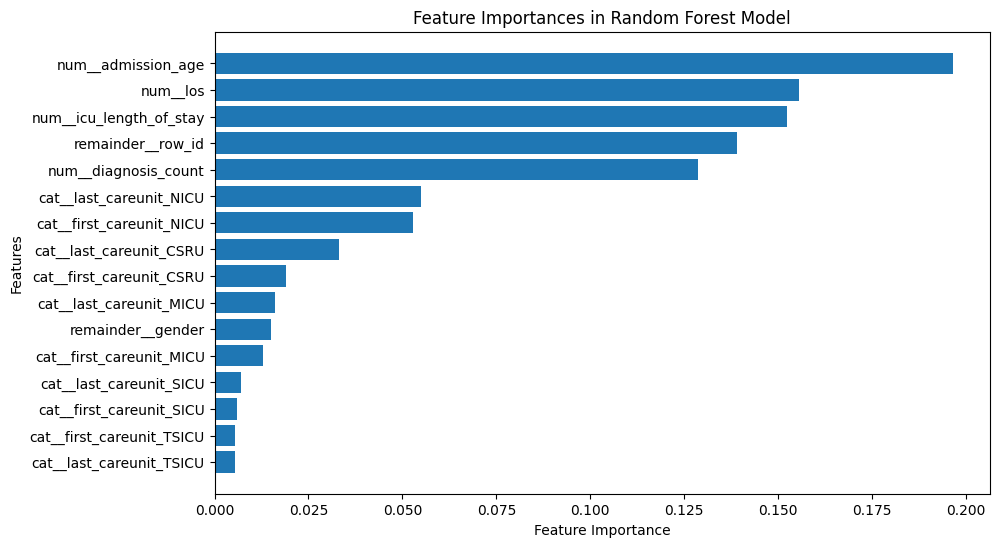

In [ ]:
# STEP 9: IDENTIFYING THE MOST INFLUENTIAL PARAMETERS FROM THE MODEL

import pandas as pd
import matplotlib.pyplot as plt

# Get feature importances from the model
feature_importances = best_model.named_steps['classifier'].feature_importances_

# Get the preprocessed feature names
# We apply the preprocessor to the training data to see the exact feature names after encoding
# Fit preprocessor on training data only and get feature names
X_train_transformed = best_model.named_steps['preprocessor'].fit_transform(X_train)
encoded_feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

# Ensure that the number of feature names matches the number of importances
if len(encoded_feature_names) == len(feature_importances):
    # Create DataFrame for feature importances
    importance_df = pd.DataFrame({
        'Feature': encoded_feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    # Plot the feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.gca().invert_yaxis()
    plt.xlabel("Feature Importance")
    plt.ylabel("Features")
    plt.title("Feature Importances in Random Forest Model")
    plt.show()
else:
    print("The lengths of feature names and importances do not match. Please recheck.")
